<a href="https://www.kaggle.com/code/zahrasyifaul/apple-vs-orange-classification-with-resnet18?scriptVersionId=259919632" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# APPLE N ORANGE CLASSIFICATION WITH RESNET18

# IMPORT LIBRARY

In [1]:
import os
import torch
import torchvision
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np

# SETUP DAN TRANSFORMASI DATA

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_dir = "/kaggle/input/fruitdataset/archive/fruit-dataset"
print(f"Using device: {device}")

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

Using device: cuda


# LOAD DATASET DAN SPLIT

In [3]:
full_dataset = datasets.ImageFolder(root=data_dir, transform=train_transform)
val_percent = 0.2
val_size = int(len(full_dataset) * val_percent)
train_size = len(full_dataset) - val_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
val_dataset.dataset.transform = test_transform

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

class_names = full_dataset.classes
print("Class names:", 'apple ,','orange')

Class names: apple , orange


# VISUALISASI SAMPEL GAMBAR

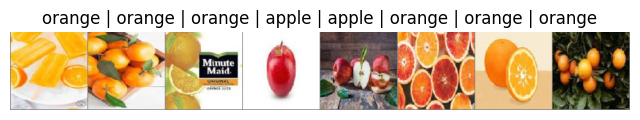

In [4]:
def imshow(img, title):
    img = img * 0.5 + 0.5
    npimg = img.numpy()
    plt.figure(figsize=(8, 4))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')
    plt.show()

data_iter = iter(train_loader)
images, labels = next(data_iter)
imshow(torchvision.utils.make_grid(images[:8]), title=' | '.join([class_names[i] for i in labels[:8]]))

# LOAD MODEL RESNET18

In [5]:
from torchvision.models import ResNet18_Weights

model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(model.fc.in_features, 1)
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 188MB/s]


# earlystopping

In [6]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss is None:
            self.best_loss = val_loss
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.counter = 0

# TRAINING DAN EVALUASI

Epoch [1/15], Train Loss: 0.5593, Val Loss: 0.3897, Val Acc: 0.8812
Epoch [2/15], Train Loss: 0.3561, Val Loss: 0.3017, Val Acc: 0.9062
Epoch [3/15], Train Loss: 0.2417, Val Loss: 0.2675, Val Acc: 0.9062
Epoch [4/15], Train Loss: 0.1961, Val Loss: 0.2418, Val Acc: 0.9250
Epoch [5/15], Train Loss: 0.1680, Val Loss: 0.2247, Val Acc: 0.9375
Epoch [6/15], Train Loss: 0.1268, Val Loss: 0.2225, Val Acc: 0.9375
Epoch [7/15], Train Loss: 0.1103, Val Loss: 0.2733, Val Acc: 0.9000
Epoch [8/15], Train Loss: 0.1062, Val Loss: 0.2072, Val Acc: 0.9250
Epoch [9/15], Train Loss: 0.1448, Val Loss: 0.2548, Val Acc: 0.8875
Epoch [10/15], Train Loss: 0.1193, Val Loss: 0.2088, Val Acc: 0.9250
Epoch [11/15], Train Loss: 0.1192, Val Loss: 0.2066, Val Acc: 0.9250
Epoch [12/15], Train Loss: 0.1775, Val Loss: 0.1842, Val Acc: 0.9437
Epoch [13/15], Train Loss: 0.1444, Val Loss: 0.1824, Val Acc: 0.9375
Epoch [14/15], Train Loss: 0.0972, Val Loss: 0.2422, Val Acc: 0.9062
Epoch [15/15], Train Loss: 0.0557, Val Loss

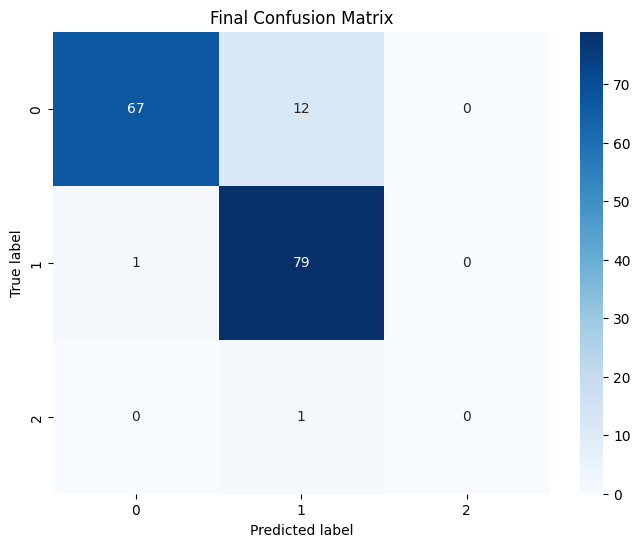

In [7]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim

# Loss dan Optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.003, weight_decay=1e-4)

early_stopping = EarlyStopping(patience=3)

num_epochs = 15
train_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device).float().unsqueeze(1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    train_losses.append(avg_loss)

    # Validation
    model.eval()
    val_loss = 0.0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for val_images, val_labels in val_loader:
            val_images = val_images.to(device)
            val_labels = val_labels.to(device).float().unsqueeze(1)
            
            val_outputs = model(val_images)
            loss = criterion(val_outputs, val_labels)
            val_loss += loss.item()

            # Simpan label & prediksi
            preds = torch.sigmoid(val_outputs) > 0.5  # threshold untuk binary classification
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(val_labels.cpu().numpy())

    val_loss /= len(val_loader)

    acc = accuracy_score(all_labels, all_preds)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {acc:.4f}")

    # Early stopping
    early_stopping(val_loss)
    if early_stopping.early_stop:
        print("Early stopping triggered!")
        break

# ✅ Confusion Matrix (pakai prediksi terakhir)
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Final Confusion Matrix")
plt.show()


# VISUALISASI LOSS KONVERGEN

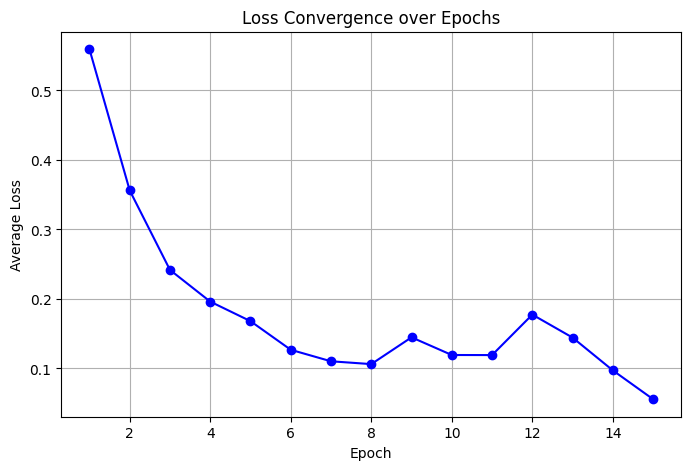

In [8]:
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, marker='o', color='blue')
plt.title("Loss Convergence over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.grid(True)
plt.show()

# PENGUJIAN GAMBAR 

Predicted: orange (Confidence: 100.00%)


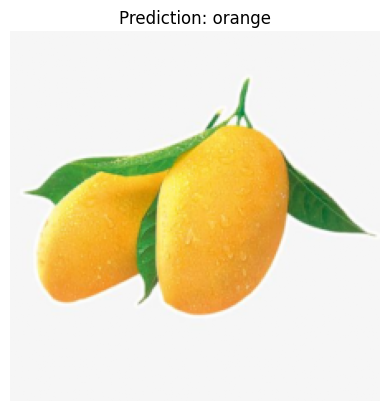

In [9]:
from PIL import Image

def predict_image(image_path, model, transform, class_names):
    # Load image
    image = Image.open(image_path).convert('RGB')
    
    # Apply same transform as test set
    image = transform(image).unsqueeze(0).to(device)

    # Set model to eval
    model.eval()
    with torch.no_grad():
        output = model(image)
        pred = torch.sigmoid(output).item()
        label = 1 if pred > 0.5 else 0
        confidence = pred if label == 1 else 1 - pred

    print(f"Predicted: {class_names[label]} (Confidence: {confidence*100:.2f}%)")

    # Show the image
    img_show = image.squeeze().cpu() * 0.5 + 0.5  # unnormalize
    npimg = img_show.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(f"Prediction: {class_names[label]}")
    plt.axis('off')
    plt.show()

# Contoh penggunaan:
# ganti '/kaggle/input/sampel/apple.jpg' dengan path gambar kamu
test_image_path = "/kaggle/input/fruitdataset/archive/fruit-dataset/train/mangga.jpg"
predict_image(test_image_path, model, test_transform, class_names)
